In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

In [2]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [3]:
dfdic = {}
for idx, x in enumerate(record_list):
    dfdic[x] = pd.read_csv('mit-bih-features/'+x+ '.csv', index_col=0)

In [4]:
subject_df = pd.DataFrame()
for idx, x in enumerate(record_list):
    subject_df = pd.concat([subject_df, dfdic[x]])

In [5]:
subject_df['Mappedrhythmlabels'] = subject_df['rhythmLabel'].map({'Normal':0, 'Other':0, 'AFIB':1})

In [6]:
subject_df.head()

,subsetID,rhythmLabel,StoS,StoR,StoL,RtoS,RtoR,RtoL,LtoS,LtoR,LtoL,RMS,STD,CoefVar,Range,IQR,MAD,Mappedrhythmlabels
0,04015-0.csv,Normal,0.200000,0.057143,0.028571,0.057143,0.228571,0.142857,0.057143,0.114286,0.114286,156.276998,43.660906,0.248152,155.0,78.00,32.5,0
1,04015-1.csv,Normal,0.000000,0.052632,0.000000,0.052632,0.184211,0.236842,0.000000,0.210526,0.263158,197.783973,57.233572,0.355262,213.0,93.50,55.0,0
2,04015-2.csv,Normal,0.333333,0.083333,0.055556,0.027778,0.305556,0.083333,0.111111,0.000000,0.000000,151.638551,43.820505,0.253179,138.0,72.00,56.0,0
3,04015-3.csv,Normal,0.300000,0.175000,0.000000,0.125000,0.025000,0.125000,0.075000,0.050000,0.125000,157.611865,48.827831,0.318730,167.0,79.00,59.0,0
4,04015-4.csv,Normal,0.090909,0.151515,0.090909,0.030303,0.060606,0.212121,0.212121,0.060606,0.090909,226.855681,53.260256,0.289227,237.0,95.75,66.5,0


In [7]:
statstd_dic = {
    'Accuracy': [],
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': [],
    "Run Time": []
}

indaccs = {}

In [8]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    
    X_train = subject_df.iloc[train_index, 12].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 12].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statstd_dic["Run Time"].append(elapsed)
statstd_dic['Accuracy'].append(np.mean(acc_score))
statstd_dic['Standard Error'].append(np.std(acc_score))
statstd_dic['Sensitivity'].append(sensitivity)
statstd_dic['Specificity'].append(specificity)
statstd_dic['Precision'].append(precision)
statstd_dic['F1_Score'].append(f1_score)

indaccs['LogReg'] = acc_score

---Run time is 0.41048920700000036 seconds ---

Accuracy of each fold: 
 [0.8263749807425667, 0.8204930662557781, 0.82326656394453, 0.8326656394453005, 0.8343605546995377]
Avg accuracy: 0.8274321610175427
Std of accuracy : 
0.005329405233002155

[[16699  2727]
 [ 2873 10152]]

              precision    recall  f1-score   support

           0       0.85      0.86      0.86     19426
           1       0.79      0.78      0.78     13025

    accuracy                           0.83     32451
   macro avg       0.82      0.82      0.82     32451
weighted avg       0.83      0.83      0.83     32451

0.8596211263255431
0.7794241842610364
0.8532086654404251
0.8564028924560234


In [9]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 12].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 12].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statstd_dic["Run Time"].append(elapsed)
statstd_dic['Accuracy'].append(np.mean(acc_score))
statstd_dic['Standard Error'].append(np.std(acc_score))
statstd_dic['Sensitivity'].append(sensitivity)
statstd_dic['Specificity'].append(specificity)
statstd_dic['Precision'].append(precision)
statstd_dic['F1_Score'].append(f1_score)

indaccs['LDA'] = acc_score

---Run time is 0.27857650000000156 seconds ---

Accuracy of each fold: 
 [0.8257587428747497, 0.8189522342064715, 0.823728813559322, 0.8306625577812018, 0.8318952234206471]
Avg accuracy: 0.8261995143684786
Std of accuracy : 
0.004715539626712511

[[16762  2664]
 [ 2976 10049]]

              precision    recall  f1-score   support

           0       0.85      0.86      0.86     19426
           1       0.79      0.77      0.78     13025

    accuracy                           0.83     32451
   macro avg       0.82      0.82      0.82     32451
weighted avg       0.83      0.83      0.83     32451

0.862864202615052
0.7715163147792706
0.8492248454757321
0.8559901950771117


In [10]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    
    X_train = subject_df.iloc[train_index, 12].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 12].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statstd_dic["Run Time"].append(elapsed)
statstd_dic['Accuracy'].append(np.mean(acc_score))
statstd_dic['Standard Error'].append(np.std(acc_score))
statstd_dic['Sensitivity'].append(sensitivity)
statstd_dic['Specificity'].append(specificity)
statstd_dic['Precision'].append(precision)
statstd_dic['F1_Score'].append(f1_score)

indaccs['QDA'] = acc_score

---Run time is 0.0931123300000003 seconds ---

Accuracy of each fold: 
 [0.8277615159451548, 0.8206471494607088, 0.8231124807395994, 0.8326656394453005, 0.8345146379044684]
Avg accuracy: 0.8277402846990464
Std of accuracy : 
0.005326923474023074

[[16683  2743]
 [ 2847 10178]]

              precision    recall  f1-score   support

           0       0.85      0.86      0.86     19426
           1       0.79      0.78      0.78     13025

    accuracy                           0.83     32451
   macro avg       0.82      0.82      0.82     32451
weighted avg       0.83      0.83      0.83     32451

0.8587974879028106
0.7814203454894434
0.8542242703533026
0.8565047746175171


In [11]:
#KNN-CV
KNN_result = []
X=subject_df["STD"].values.reshape(-1,1)
Y=subject_df["Mappedrhythmlabels"]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,31):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K = {}'.format(k))
    print('Accuracy of each fold: \n {}'.format(scores))
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(np.max(KNN_result))

K = 1
Accuracy of each fold: 
 [0.77522724 0.77211094 0.77719569 0.78151002 0.78151002]
Avg accuracy: 0.7775107788216422

K = 2
Accuracy of each fold: 
 [0.74672624 0.74283513 0.75007704 0.75208012 0.75223421]
Avg accuracy: 0.748790547727694

K = 3
Accuracy of each fold: 
 [0.79417655 0.79491525 0.8009245  0.80385208 0.80909091]
Avg accuracy: 0.8005918589660354

K = 4
Accuracy of each fold: 
 [0.7852411  0.78228043 0.79198767 0.78844376 0.79614792]
Avg accuracy: 0.7888201774698593

K = 5
Accuracy of each fold: 
 [0.80357418 0.80986133 0.81248074 0.81417565 0.81432974]
Avg accuracy: 0.8108843274520915

K = 6
Accuracy of each fold: 
 [0.80033893 0.80154083 0.80246533 0.80770416 0.80631741]
Avg accuracy: 0.8036733331608374

K = 7
Accuracy of each fold: 
 [0.81682329 0.81263482 0.81525424 0.82080123 0.82403698]
Avg accuracy: 0.8179101133037353

K = 8
Accuracy of each fold: 
 [0.81189339 0.81386749 0.81109399 0.81694915 0.82095532]
Avg accuracy: 0.8149518676921156

K = 9
Accuracy of each fo

In [12]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=7)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    
    X_train = subject_df.iloc[train_index, 12].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 12].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print()


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statstd_dic["Run Time"].append(elapsed)
statstd_dic['Accuracy'].append(np.mean(acc_score))
statstd_dic['Standard Error'].append(np.std(acc_score))
statstd_dic['Sensitivity'].append(sensitivity)
statstd_dic['Specificity'].append(specificity)
statstd_dic['Precision'].append(precision)
statstd_dic['F1_Score'].append(f1_score)

indaccs['KNN-CV'] = acc_score


---Run time is 3.3498113059999923 seconds ---

Accuracy of each fold: 
 [0.8168232937914035, 0.8126348228043143, 0.8152542372881356, 0.8208012326656394, 0.8240369799691833]
Avg accuracy: 0.8179101133037353
Std of accuracy : 
0.004048718568062232

[[15664  3762]
 [ 2147 10878]]

              precision    recall  f1-score   support

           0       0.88      0.81      0.84     19426
           1       0.74      0.84      0.79     13025

    accuracy                           0.82     32451
   macro avg       0.81      0.82      0.81     32451
weighted avg       0.82      0.82      0.82     32451

0.8063420158550396
0.8351631477927063
0.8794565156364045
0.8413137470795177


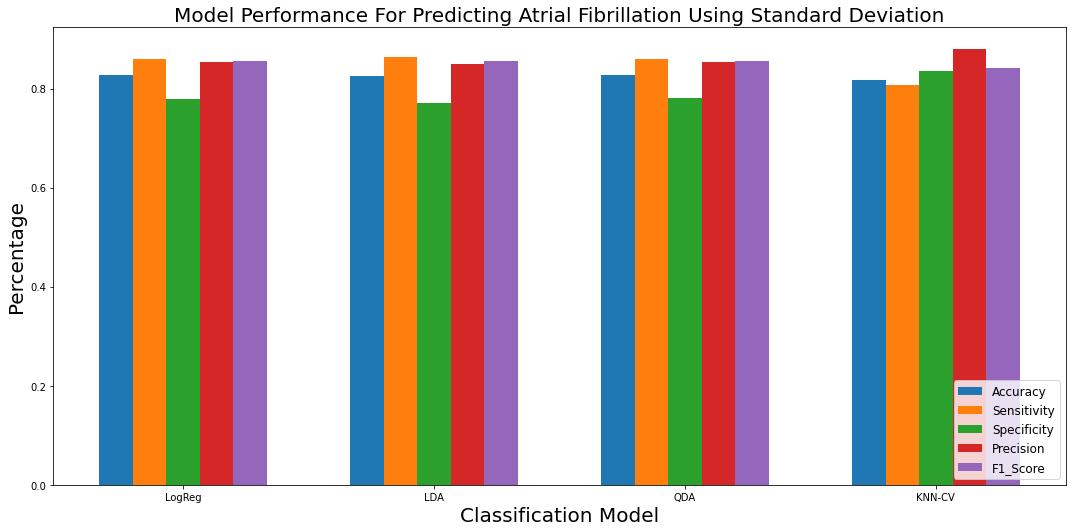

In [13]:
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
accuracies = statstd_dic["Accuracy"]
sensitivities = statstd_dic["Sensitivity"]
specificities = statstd_dic["Specificity"]
precisions = statstd_dic["Precision"]
f1_scores = statstd_dic["F1_Score"]



x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(15, 7.5))
acc = ax.bar(x-width*2, accuracies, width, label='Accuracy')
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity')
spe = ax.bar(x,specificities, width, label='Specificity')
pre = ax.bar(x+width, precisions, width, label='Precision')
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score')

ax.set_xlabel('Classification Model', fontsize=20)
ax.set_ylabel('Percentage', fontsize=20)
ax.set_title('Model Performance For Predicting Atrial Fibrillation Using Standard Deviation', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


fig.tight_layout()

plt.legend(loc="lower right", prop={'size': 12})
plt.show()

fig.savefig('StdModel.png')

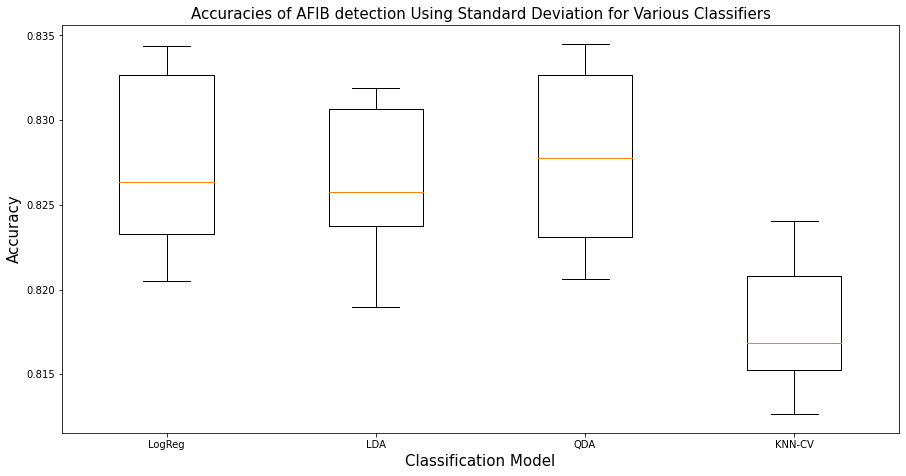

In [14]:
#Box Plots

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs['LogReg']
LDAAcc = indaccs['LDA']
QDAAcc = indaccs['QDA']
KNNAcc = indaccs['KNN-CV']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
ax.boxplot(data)

ax.set_title('Accuracies of AFIB detection Using Standard Deviation for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

plt.show()

fig.savefig('StdBox.png')

In [15]:
stddf = pd.DataFrame(
    data = np.transpose(np.array([
                                statstd_dic["Accuracy"],
                                statstd_dic["Standard Error"],
                                statstd_dic["Sensitivity"],
                                statstd_dic["Specificity"],
                                statstd_dic["Precision"],
                                statstd_dic["F1_Score"],
                                statstd_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

stddf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.827432,0.005329,0.859621,0.779424,0.853209,0.856403,0.410489
LDA,0.826200,0.004716,0.862864,0.771516,0.849225,0.855990,0.278577
QDA,0.827740,0.005327,0.858797,0.781420,0.854224,0.856505,0.093112
KNN-CV,0.817910,0.004049,0.806342,0.835163,0.879457,0.841314,3.349811
